In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import os

In [2]:
# Cell 2: Load Recent Data Function (with debug)
def load_recent_data(file_path, days=30):
    print(f"Attempting to access file: {file_path}")
    try:
        with open(file_path, 'r') as f:
            print("File can be opened successfully!")
    except Exception as e:
        print(f"Failed to open file: {e}")
        raise
    
    data = pd.read_csv(file_path)
    data[data.columns[0]] = pd.to_numeric(data[data.columns[0]], errors='coerce')
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit='s')
    data.set_index(data.columns[0], inplace=True)
    data.dropna(inplace=True)
    end_date = data.index.max()
    start_date = end_date - timedelta(days=days)
    mask = (data.index >= start_date) & (data.index <= end_date)
    filtered_data = data.loc[mask]
    print(f"Data range: {filtered_data.index.min()} to {filtered_data.index.max()}")
    print(f"Total data points: {len(filtered_data)}")
    return filtered_data

# Cell 8: Main Execution
import os

file_path = r'C:\Users\User\bitcoin_historical_data_clean.csv'  # Add .csv if needed

try:
    model, scaler, data = train_model_with_recent_data(file_path, days=30, epochs=20)
    X, _, _ = create_sequences(data, seq_length=10)
    last_known_sequence = X[-1]
    future_prices = predict_prices(model, last_known_sequence, scaler, steps=5)
    
    print("\nPredicted Future Prices (USD):")
    for i, price in enumerate(future_prices):
        print(f"t+{i+1}: ${price:.2f}")
    
    save_directory = r'C:\Users\User'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created new directory: {save_directory}")
    else:
        print(f"Using existing directory: {save_directory}")
    
    model_path = os.path.join(save_directory, 'bitcoin_model')
    scaler_path = os.path.join(save_directory, 'scaler.json')
    
    save_model_and_scaler(model, scaler, model_dir=model_path, scaler_path=scaler_path)

except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: name 'train_model_with_recent_data' is not defined


In [3]:
# Cell 3: Create Sequences Function
def create_sequences(data, seq_length=10):
    # Select features for prediction
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Ensure all required columns exist
    missing_columns = [col for col in features if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")
    
    # Normalize the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(scaled_data[i+seq_length, 3])  # Predicting next Close price
    
    return np.array(X), np.array(y), scaler

In [4]:
# Cell 4: Build Model Function
def build_simplified_model(seq_length, feature_count):
    model = tf.keras.Sequential([
        # Simplified model with fewer layers
        tf.keras.layers.LSTM(30, activation='relu', 
                            input_shape=(seq_length, feature_count)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer for price prediction
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

In [5]:
# Cell 5: Train Model Function
def train_model_with_recent_data(file_path, days=30, seq_length=10, epochs=20):
    """
    Train a model using the most recent days of data
    """
    # Load data
    data = load_recent_data(file_path, days=days)
    
    # Create sequences
    X, y, scaler = create_sequences(data, seq_length)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build model
    model = build_simplified_model(seq_length, X.shape[2])
    
    # Train model
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=32, 
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")
    print(f"Test MAE: {mae}")
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler, data

In [6]:
def predict_prices(model, last_sequence, scaler, steps=5):
    """
    Predict future prices based on the last known sequence.
    
    Parameters:
    model: Trained TensorFlow model
    last_sequence: The last sequence of data points
    scaler: The MinMaxScaler used to normalize the data
    steps: Number of future steps to predict
    
    Returns:
    List of predicted prices
    """
    current_seq = last_sequence.copy()
    predictions = []
    
    for _ in range(steps):
        # Reshape for prediction
        current_reshape = current_seq.reshape(1, current_seq.shape[0], current_seq.shape[1])
        
        # Predict next normalized value
        next_pred = model.predict(current_reshape, verbose=0)
        
        # Create a dummy row with the predicted value in the Close position (index 3)
        dummy_row = np.zeros((1, scaler.n_features_in_))
        dummy_row[0, 3] = next_pred[0, 0]  # Place prediction in the Close column
        
        # Inverse transform to get the actual price
        next_pred_actual = scaler.inverse_transform(dummy_row)[0, 3]
        predictions.append(next_pred_actual)
        
        # Update sequence for next prediction
        # 1. Roll the sequence to remove the oldest entry
        current_seq = np.roll(current_seq, -1, axis=0)
        
        # 2. Update the newest entry with previous values except Close
        current_seq[-1, :] = current_seq[-2, :]
        
        # 3. Update Close with the new prediction (normalized)
        current_seq[-1, 3] = next_pred[0, 0]
    
    return predictions

In [7]:
# Cell 7: Save Model and Scaler Function
def save_model_and_scaler(model, scaler, model_dir='model', scaler_path='scaler.json'):
    os.makedirs(os.path.dirname(model_dir) if os.path.dirname(model_dir) else '.', exist_ok=True)
    os.makedirs(os.path.dirname(scaler_path) if os.path.dirname(scaler_path) else '.', exist_ok=True)
    
    model.save(model_dir)
    print(f"Model saved to {model_dir}")
    
    scaler_params = {
        'min_': scaler.min_.tolist() if hasattr(scaler, 'min_') else None,
        'scale_': scaler.scale_.tolist() if hasattr(scaler, 'scale_') else None,
        'data_min_': scaler.data_min_.tolist() if hasattr(scaler, 'data_min_') else None,
        'data_max_': scaler.data_max_.tolist() if hasattr(scaler, 'data_max_') else None,
        'data_range_': scaler.data_range_.tolist() if hasattr(scaler, 'data_range_') else None,
        'n_features_in_': scaler.n_features_in_ if hasattr(scaler, 'n_features_in_') else None,
        'n_samples_seen_': int(scaler.n_samples_seen_) if hasattr(scaler, 'n_samples_seen_') else None
    }
    
    with open(scaler_path, 'w') as f:
        json.dump(scaler_params, f)
    
    print(f"Scaler saved to {scaler_path}")

Attempting to access file: C:\Users\User\DataFiles\btcusd_1min_data.csv
File can be opened successfully!
Data range: 2025-02-07 00:00:00 to 2025-03-09 00:00:00
Total data points: 19001


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1476 - mae: 0.2383 - val_loss: 0.0013 - val_mae: 0.0320
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - mae: 0.0303 - val_loss: 0.0023 - val_mae: 0.0450
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0943e-04 - mae: 0.0191 - val_loss: 0.0020 - val_mae: 0.0420
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.8960e-04 - mae: 0.0138 - val_loss: 0.0025 - val_mae: 0.0453
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.1948e-04 - mae: 0.0122 - val_loss: 0.0027 - val_mae: 0.0482
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.8262e-04 - mae: 0.0102 - val_loss: 0.0024 - val_mae: 0.0454
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.8312e-04 - mae: 0.0097 - val_loss: 0.0025 - val_mae: 0.0457
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.2373e-04 - mae: 0.0092 - val_loss: 0.0025 - val_mae: 0.0460
Epoch 9/20
380/380 ━━━━━━━━━━━━━

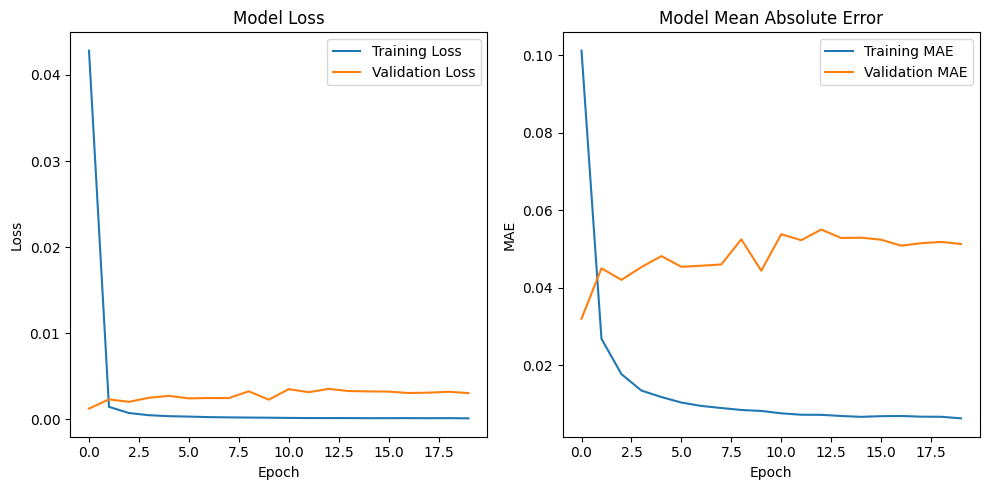


Predicted Future Prices (USD):
t+1: $85718.88
t+2: $85666.82
t+3: $85632.74
t+4: $85609.94
t+5: $85595.02
Using existing directory: C:\Users\User
Model saved to C:\Users\User\bitcoin_model.keras
Scaler saved to C:\Users\User\scaler.json
Model saved successfully. Indicator file: None


In [9]:
# Cell 8: Main Execution
file_path = r'C:\Users\User\DataFiles\btcusd_1min_data.csv'

try:
    # Train model
    model, scaler, data = train_model_with_recent_data(
        file_path, 
        days=30,
        epochs=20
    )
    
    # Create sequences
    X, _, _ = create_sequences(data, seq_length=10)
    last_known_sequence = X[-1]
    
    # Predict
    future_prices = predict_prices(model, last_known_sequence, scaler, steps=5)
    
    print("\nPredicted Future Prices (USD):")
    for i, price in enumerate(future_prices):
        print(f"t+{i+1}: ${price:.2f}")
    
    # Save model and scaler with proper file extension
    save_directory = r'C:\Users\User'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created new directory: {save_directory}")
    else:
        print(f"Using existing directory: {save_directory}")
    
    # Add .keras extension to model filename
    model_path = os.path.join(save_directory, 'bitcoin_model.keras')
    scaler_path = os.path.join(save_directory, 'scaler.json')
    
    # Modified save_model_and_scaler function call (if you're using the function from previous examples)
    # If you're using the original function without the indicator, use model.save(model_path) directly
    success_file = save_model_and_scaler(model, scaler, model_dir=model_path, scaler_path=scaler_path)
    print(f"Model saved successfully. Indicator file: {success_file}")
    
except Exception as e:
    print(f"An error occurred: {e}")